# Chapter 4 . Building Style Transfer Pipeline in Keras 

## Unit 1. A brief recap 

In this chapter we will learn to implement and train a style transfer network to create cool outputs. Before we move to the crux of the pipeline, let us refresh the concepts we learnt previous chapters in a very concise manner. 

We learnt that style transfer is a way to fuse the content and style of 2 images to generate an output image which looks like a realistic fusion of the content and style. These 2 input images are the **Style** and the **Content** images. Generally the style image can be a famous painting and the content image can be any image of choice, preferably with an object of interest like a house, bridge, face etc. 

In order to fuse the style and content, we need to first extract them from their respective images. We use a pretrained CNN like VGG-19 for this purpose. The content is extracted from the end layers of the CNN and style is extracted from the earlier layers. Please refer to chapter 1 for more detailed information about the same. 

Once we extracted the style and content, we formulated the losses. We looked at 3 kinds of losses 
* **L<sub>content</sub>** is the Content Loss 
* **L<sub>style</sub>** is the Style Loss 
* **L<sub>tv</sub>** is the Total Variance Loss

These losses are multiplied by their respective weights (alpha and beta) and combined to form the Total loss **L<sub>total</sub>** 

### **L<sub>total</sub>**   =   alpha ***L<sub>content</sub>**  +  beta ***L<sub>style</sub>**   +  gamma * **L<sub>tv</sub>** 

Now we will move ahead and use all the above concept to build a Style Transfer Pipeline. 

The code draws lot of inspiration from the Neural Style Transfer Implementation at https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py which is one of the cleanest implementations in Keras

## Unit 2.  The pipeline

As any common neural network, the objective here is to design our pipeline to minimize the total loss mentioned above. We are going to use Keras to build our network. 

The requirements are as follows :

In [1]:
import keras
import  tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

print("Tensorflow version >= " , tf.__version__)
print("Keras version >= " , keras.__version__)
print("Numpy version >= " , np.__version__)
print("Matplotlib version >= " , matplotlib.__version__)

Using TensorFlow backend.


Tensorflow version >=  1.8.0
Keras version >=  2.2.0
Numpy version >=  1.14.3
Matplotlib version >=  2.2.2


In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import os
from keras.applications import vgg19
from keras import backend as K

In [3]:
def mkdir(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### USER INPUTS

In [4]:
############## Content and Style Image paths 
content_image_path = 'images/content_imgs/monalisa.jpg'
style_image_path = 'images/style_imgs/style1.jpg'
out_folder = 'ST_results'
mkdir(out_folder)

############## Different Loss weight components
content_weight = 0.5 #alpha
style_weight = 0.5 #beta
total_variation_weight = 0.5  #gamma

iterations = 10 #Number of iteration to optimise the Total-Loss


############## Generated (output) Image Dimensions
width, height = load_img(content_image_path).size
img_nrows = 400 #Height of generated image
img_ncols = int(width * img_nrows / height)#Width of generated image
generated_imsize = (img_nrows , img_ncols)


## Preprocessing and Deprocessing of the images to suit VGG-19 requirements

As explained in Chapter 1, the pretrained VGG models follow specific preprocessing technique for the training images (ImageNet). We need to follow the same preprocessing steps in order to better use the features of the VGG model. The keras vgg19 module has it's own **preprocess_input** method which we will use for this purpose.

The following steps happen under the hood of **preprocess_input** function : 

* Crop the image to dimensions 224 x 224 which is standard input image size for VGG-net
* Horizontal flip 
* Normalise the image by 255.0 to get values from 0 to 1
* Mean subtract each channel by ImageNet specfic mean values 
        Red_MEAN = 0.485 (123.68 if not normalised)
        Green_MEAN = 0.456 (116.779 if not normalised )
        Blue_MEAN = 0.406 (103.939 if not normalised )
            
Once we get the necessary results/features from the model, we have to get them back to original image space using deprocessing function. The deprocessing function basically restores the pixel values in the output image to their original values before normalization. 

In [1]:
# Load the image from it's filename and resize it to the target size (224x224)
def prepare_img_array(img_path , target_size = (224,224)):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Preprocess the image based on vgg preprocessing function
def preprocess_image(img):
    img = vgg19.preprocess_input(np.copy(img))
    return img

# Deprocess the processed image 
def deprocess_image(img , img_nrows , img_ncols):
    img = np.copy(img_preprocessed)
    if K.image_data_format() == 'channels_first':
        img = img.reshape((3, img_nrows, img_ncols))
        img = img.transpose((1, 2, 0))
    else:
        img = img.reshape((img_nrows, img_ncols, 3))
    print(img.shape)
    # Remove zero-center by mean pixel based on VGG standard values
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

## Visualisations

In [6]:
# get tensor representations of our images
content_image = prepare_img_array(content_image_path , generated_imsize)
style_image = prepare_img_array(style_image_path , generated_imsize)

content_image_pp = preprocess_image(content_image)
style_image_pp = preprocess_image(style_image)

content_image_dp = deprocess_image(content_image_pp, img_nrows , img_ncols)
style_image_dp = deprocess_image(style_image_pp, img_nrows , img_ncols)

orig_image = content_image


(400, 264, 3)
(400, 264, 3)


Orig Image


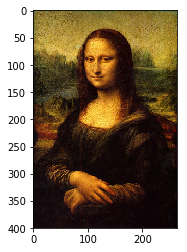

Preprocessed Image


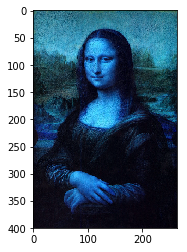

Deprocessed Image


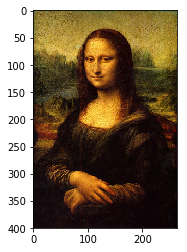

In [7]:
print("Orig Image")
plt.imshow(orig_image[0].astype('uint8'))
plt.show()
print("Preprocessed Image")
plt.imshow(content_image_pp[0].astype('uint8'))
plt.show()
print("Deprocessed Image")
plt.imshow(content_image_dp.astype('uint8'))
plt.show()

## Create a composite tensor to hold Content Image , Style Image and Generated (Combined) Image

In [8]:
# Convert images from array to tensor
content_image_pp = K.variable(content_image_pp)
style_image_pp = K.variable(style_image_pp)

# Preparing the tensor for holding the generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([content_image_pp,
                              style_image_pp,
                              combination_image], axis=0)

## VGG-19 Model 

Here we load the pretrained VGG-19 model (inbuilt in Keras) and print the summary

In [9]:
def load_VGG19(input_tensor , include_top=False):
    """
     include_top: whether to include the 3 fully-connected layers at the top of the network.
     weights: one of None (random initialization) or 'imagenet' (pre-training on ImageNet)
     input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model
     
     More options at : 
     https://keras.io/applications/#extract-features-from-an-arbitrary-intermediate-layer-with-vgg19
    """
    model = vgg19.VGG19(input_tensor=input_tensor , include_top=include_top,weights='imagenet') # input_tensor=input_tensor 
    return model 

include_top = False
vgg19_model = load_VGG19(input_tensor,include_top)
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
# Make a dictionary of layers of the loaded VGG-19 model with the layer names as the keys for further use 
outputs_dict = dict([(layer.name, layer.output) for layer in vgg19_model.layers])
outputs_dict

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 264, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 264, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 264, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 132, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 132, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 132, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 66, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 66, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 66, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 66, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 66, 256) dtype=float32>,
 'block3_pool': <tf.Ten

## Loss Functions

### Content Loss (L<sub>content</sub>)

In [11]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

### Gram Matrix and Style Loss (L<sub>style</sub>)

In [12]:
# Gram matrix creation function
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# Style loss calculation
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

### Total Variation Loss (L<sub>tv</sub>)

In [13]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Features Extraction from VGG-19 and initialisation of loss and gradients

In [14]:
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    
    
loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)

## Evaluation function to calculate the gradient and losses  

In [15]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Optimising the the losses and generating the output 

The Evaluator() class defined above provides methods to access loss and gradients.Now we have a computation graph ready . How do we optimize it?
There are many optimisation techniques ranging from simplest (like gradient_descent) to most sophisticated ones (like ADAM) 

In this case, for ease of implementation we can use limited memory BFGS, from scipy.optimize package. It helps us optimise our loss functions easily without breaking our head on the implementation part. Please have a look at https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html#scipy-optimize-fmin-l-bfgs-b for more details.

In [16]:
from scipy.optimize import fmin_l_bfgs_b
x = preprocess_image(content_image)
generated_images = []
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy() , img_nrows , img_ncols)
    fname = out_folder + '/out_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    generated_images.append(img)

Start of iteration 0
Current loss value: 3560979500.0
(400, 264, 3)
Image saved as ST_results/out_at_iteration_0.png
Iteration 0 completed in 4s
Start of iteration 1
Current loss value: 2089033900.0
(400, 264, 3)
Image saved as ST_results/out_at_iteration_1.png
Iteration 1 completed in 2s
Start of iteration 2
Current loss value: 1665518800.0
(400, 264, 3)
Image saved as ST_results/out_at_iteration_2.png
Iteration 2 completed in 2s
Start of iteration 3
Current loss value: 1477214600.0
(400, 264, 3)
Image saved as ST_results/out_at_iteration_3.png
Iteration 3 completed in 2s
Start of iteration 4
Current loss value: 1349511600.0
(400, 264, 3)
Image saved as ST_results/out_at_iteration_4.png
Iteration 4 completed in 3s
Start of iteration 5
Current loss value: 1256904700.0
(400, 264, 3)
Image saved as ST_results/out_at_iteration_5.png
Iteration 5 completed in 2s
Start of iteration 6
Current loss value: 1185740900.0
(400, 264, 3)
Image saved as ST_results/out_at_iteration_6.png
Iteration 6 c

## Visualisations
Have a look at the changes in smoothness of the generated image as we move through the iterations

Content Image


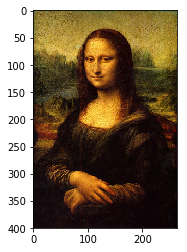



Style Image


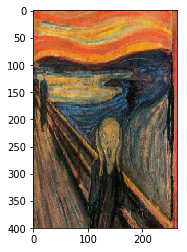



================= Iteration :  0


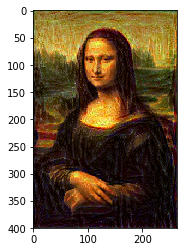



================= Iteration :  2


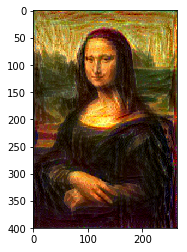



================= Iteration :  4


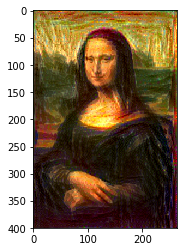



================= Iteration :  6


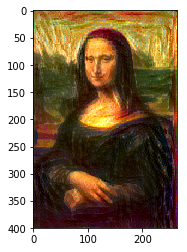



================= Iteration :  8


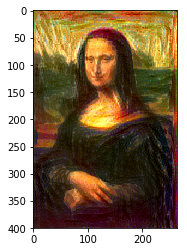

In [17]:
print("Content Image")
plt.imshow(content_image_dp.astype('uint8'))
plt.show()

print("\n\nStyle Image")
plt.imshow(style_image_dp.astype('uint8'))
plt.show()

for i,g in enumerate(generated_images):
    if i%2 == 0 :
        print("\n\n================= Iteration : ",i)
        plt.imshow(g)
        plt.show()

## Exercises

* There is a colab notebook "colab_notebook/Chapter4_The_StyleTransfer_pipeline_Colab.ipynb" which has the same code implemented. You can use that as well. 
* Try out different examples for content images and style images and check the outputs
* Tune the parameters like content weight , style weight , total variation weights and observe the magic in the output 
* For style loss, try using the same equation as content loss and observe the change in the output
* Try increasing the number of iterations  

## References :

* https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py
* https://github.com/robertomest/neural-style-keras/blob/master/fast_style_transfer.py
* https://arxiv.org/abs/1508.06576
* https://paperswithcode.com/task/style-transfer
* https://datascience-enthusiast.com/DL/Art_Generation_with_Neural_Style_Transfer_v2.html  (Implementation)
* https://d2l.ai/chapter_computer-vision/neural-style.html (Implementation)
 

## Unit 3. Quiz 

Following are the quizzes for Chapter 4

### 1. Which is the optimization function used in this chapter   

    a. Stochastic Gradient Descent (SGD)
    b. ADAM
    c. L_BGFS_B (fmin_l_bfgs_b)
    d. None of the above

### 2. Which of the below layer names doesn't belong to the pretrained VGG-19 model 

    a. block1_pool
    b. block5_conv2
    c. input_1
    d. block2_conv3 
    
### 3. Which of the following sequences indicate the mean pixel values to used during preprocessing of images for VGG model   

    a. (R : 128 , G : 128 , B : 128)
    b. (R : 123.68 , G : 116.779 , B : 103.939)
    c. (R : 103.939 , G : 116.779 , B : 123.68 )
    d. (R : 123.33 , G : 127.21 , B : 129.36)

### Answers :

**1. c ** 
   - Hint : This chapter uses L_BGFS_B optimisation ie., scipy.optimize.fmin_l_bfgs_b()

**2. d ** 
   - Hint : The block 2 in VGG-19 has only 2 convolution layers (conv1, conv2)
  
**3. b ** 
   - Hint : The mean pixel values used in the preprocessing of VGG models are 
     `(R : 123.68 , G : 116.779 , B : 103.939)`